In [421]:
#计算置信区间
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score,confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
#统计模型
import statsmodels.api as sm
#用来显示中文标签
plt.rcParams['font.sans-serif']=['SimHei']
#用来正常显示负号
plt.rcParams['axes.unicode_minus']=False

In [422]:
#加载数据
df = pd.read_excel('去除重复数据眼底和临床.xlsx',sheet_name="眼底和临床清洗")
# df2= pd.read_csv('finalScore.csv')
#祛除重复数据
df = df.drop_duplicates()
#包含有101个Nan
print(df.isnull().sum().sum())
#将Nan替换为各列的均值，否则建模时报错
df = df.fillna(df.mean())

1666


C:\Users\count\AppData\Local\Temp\ipykernel_21000\3970251911.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())


In [423]:
#临床资料
df1 = df[['*肌酐(酶法)','gender','总胆固醇','空腹血糖','age','y']]
df1 = df1.drop_duplicates()
# df1.info()
df1.describe()

,*肌酐(酶法),gender,总胆固醇,空腹血糖,age,y
count,1420.000000,1420.00000,1420.000000,1420.000000,1420.000000,1420.000000
mean,68.494608,1.46897,4.188203,6.280043,61.852609,22.849356
std,18.723230,0.49886,1.146402,1.791998,10.289543,31.542403
min,27.000000,1.00000,1.540000,2.100000,24.000000,0.000000
25%,56.000000,1.00000,3.357500,5.200000,56.000000,0.000000
50%,67.000000,1.00000,4.000000,5.800000,62.000000,10.000000
75%,78.000000,2.00000,4.832500,6.800000,69.000000,32.000000
max,228.000000,2.00000,10.600000,19.100000,90.000000,296.000000


In [424]:
df1

,*肌酐(酶法),gender,总胆固醇,空腹血糖,age,y
0,65.0,1.0,8.48,5.4,39.0,0.0
1,56.0,2.0,3.70,5.9,59.0,0.0
2,91.0,1.0,3.18,5.9,71.0,8.0
3,60.0,1.0,5.40,6.9,69.0,50.0
4,70.0,1.0,3.88,7.7,51.0,60.0
...,...,...,...,...,...,...
1474,61.0,2.0,5.65,5.2,68.0,0.0
1475,71.0,2.0,5.74,4.8,58.0,0.0
1476,69.0,1.0,5.27,4.6,49.0,0.0
1477,65.0,2.0,3.88,6.1,68.0,14.0


In [425]:
#用临床指标进行逻辑回归
#将gesini连续数据离散化（二值化）小于4为0，大于等于4为1
from sklearn.preprocessing import Binarizer
# help(Binarizer)
# reshape(-1,1)的意思是 请帮我将数据规整为任意行（-1)，1列,这是对列进行增维，类为特征专用，不能使用一维数据
df1_0 = df1.iloc[:,-1].values.reshape(-1,1)
# print(df1_0)
# print(df1.iloc[:,-1].values)
binarizer = Binarizer(threshold = 4).fit_transform(df1_0)#thresold阈值
df1.loc[:,"y"] = binarizer
df1.describe()

,*肌酐(酶法),gender,总胆固醇,空腹血糖,age,y
count,1420.000000,1420.00000,1420.000000,1420.000000,1420.000000,1420.000000
mean,68.494608,1.46897,4.188203,6.280043,61.852609,0.638028
std,18.723230,0.49886,1.146402,1.791998,10.289543,0.480740
min,27.000000,1.00000,1.540000,2.100000,24.000000,0.000000
25%,56.000000,1.00000,3.357500,5.200000,56.000000,0.000000
50%,67.000000,1.00000,4.000000,5.800000,62.000000,1.000000
75%,78.000000,2.00000,4.832500,6.800000,69.000000,1.000000
max,228.000000,2.00000,10.600000,19.100000,90.000000,1.000000


In [426]:
#两类数据是否均衡
category_counts = df1['y'].value_counts()
print(category_counts)

1.0    906
0.0    514
Name: y, dtype: int64


In [427]:
# 需要自行添加逻辑回归所需的intercept变量
# df2['intercept'] = 1.0
#划分特征变量和目标变量
X = df1.drop(columns="y")
y = df1["y"]
# #拆分数据。保留验证（训练-测试分离）/Hold-out validation (train-test split)
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(x,y,train_size=0.8)
#模型搭建
model = LogisticRegression()
# mode1.fit(X_train,y_train)
# mode1
# y_pred = mode1.predict(X_test)
# y_pred[0:10]

In [428]:
# 交叉验证计算指标,每一次挑选其中 1 份作为测试集，剩余 k-1 份作为训练集用于模型训练。
#1420例要分为整数才能保证每个folder数量一致
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# auc_scores = cross_val_score(model, X, y, cv=kf, scoring='roc_auc')
# accuracy_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
# specificity_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='specificity')
# sensitivity_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='sensitivity')

# 计算特异度和灵敏度
specificity_scores = []
sensitivity_scores = []
accuracy_scores = []
auc_scores = []

tpr_list = []
fpr_list = []

In [429]:
#查看样本数是否一致
for fold, (train_index, test_index) in enumerate(kf.split(X,y)):
    print(f"Fold {fold}:")
    print(f"  Train indices: {train_index.shape}")
    print(f"  Test indices: {test_index.shape}")

Fold 0:
  Train indices: (1136,)
  Test indices: (284,)
Fold 1:
  Train indices: (1136,)
  Test indices: (284,)
Fold 2:
  Train indices: (1136,)
  Test indices: (284,)
Fold 3:
  Train indices: (1136,)
  Test indices: (284,)
Fold 4:
  Train indices: (1136,)
  Test indices: (284,)


In [430]:
for fold, (train_index, test_index) in enumerate(kf.split(y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)

    auc_scores.append(roc_auc_score(y_test, y_pred_proba))
    accuracy_scores.append(accuracy_score(y_test, y_pred))


    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, drop_intermediate=False)#drop_intermediate=False 不省略数值
    tpr_list.append(tpr)
    fpr_list.append(fpr)

   


# 计算95%置信区间
def calculate_confidence_interval(scores):
    mean = np.mean(scores)
    std = np.std(scores)
    n = len(scores)
    z = 1.96  # 95% 置信水平的Z值
    lower_bound = mean - (z * std / np.sqrt(n))
    upper_bound = mean + (z * std / np.sqrt(n))
    return lower_bound, upper_bound

auc_ci = calculate_confidence_interval(auc_scores)
accuracy_ci = calculate_confidence_interval(accuracy_scores)
specificity_ci = calculate_confidence_interval(specificity_scores)
sensitivity_ci = calculate_confidence_interval(sensitivity_scores)

print("AUC 95% 置信区间:", auc_ci) 
print("准确率 95% 置信区间:", accuracy_ci)
print("特异度 95% 置信区间:", specificity_ci)
print("灵敏度 95% 置信区间:", sensitivity_ci)

AUC 95% 置信区间: (0.6772947552573625, 0.7376825707023802)
准确率 95% 置信区间: (0.6857906582604552, 0.7043501868099675)
特异度 95% 置信区间: (0.3799520954785306, 0.408054446189954)
灵敏度 95% 置信区间: (0.8500648914015718, 0.884435367634318)


In [431]:
tpr_list
print(f"The length of the list is: {len(tpr_list)}")
#查看五个list里的数据个数（长度）
[len(x) for x in tpr_list]
# print(f"The number of sublists in the list of lists is: {num_sublists}")

The length of the list is: 5


[285, 285, 285, 285, 285]

In [432]:
mean_tpr = np.mean(tpr_list, axis=0)
# print(mean_tpr)
mean_fpr = np.linspace(0, 1, 285)
print (mean_tpr.dtype)
print("len(z) = ",len(mean_tpr))
print("z.size = ", mean_tpr.size)
print("z.shape = ", mean_tpr.shape)

float64
len(z) =  285
z.size =  285
z.shape =  (285,)


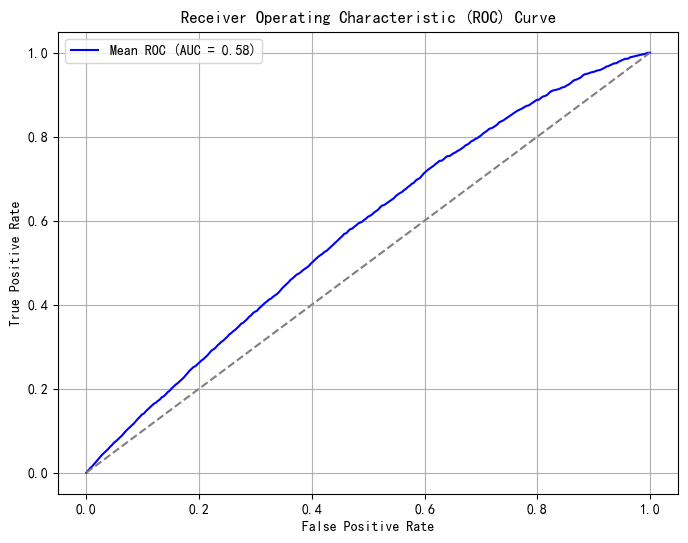

In [433]:
#  Compute mean ROC curve
mean_tpr = np.mean(tpr_list, axis=0)
mean_fpr = np.linspace(0, 1, 285)

# Compute AUC (Area Under the Curve)
roc_auc = auc(mean_fpr, mean_tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

In [434]:
auc_ci

(0.6772947552573625, 0.7376825707023802)